In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

# dataset

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'c7183fbdc3b14635bc0080c5baf22df7')

In [22]:
search_images_bing

<function __main__.search_images_bing(key, term, min_sz=128, max_images=500)>

In [50]:
results = search_images_bing(key, 'rabbit')
ims = results.attrgot('content_url')
len(ims)

150

In [51]:
kpop_types = 'rabbit','nayeon twice','jungkook bts'
path = Path('kpop')

In [52]:
if not path.exists():
    path.mkdir()
    for o in kpop_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [53]:
fns = get_image_files(path)
fns

(#438) [Path('kpop/rabbit/00000006.jpg'),Path('kpop/rabbit/00000005.jpg'),Path('kpop/rabbit/00000001.jpg'),Path('kpop/rabbit/00000002.jpg'),Path('kpop/rabbit/00000003.jpg'),Path('kpop/rabbit/00000007.jpg'),Path('kpop/rabbit/00000000.jpg'),Path('kpop/rabbit/00000009.jpg'),Path('kpop/rabbit/00000010.jpg'),Path('kpop/rabbit/00000012.jpg')...]

In [54]:
failed = verify_images(fns)
failed

(#3) [Path('kpop/rabbit/00000028.jpg'),Path('kpop/rabbit/00000058.jpg'),Path('kpop/jungkook bts/00000015.jpg')]

In [55]:
failed.map(Path.unlink);

In [56]:
kpop = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [57]:
dls = kpop.dataloaders(path)

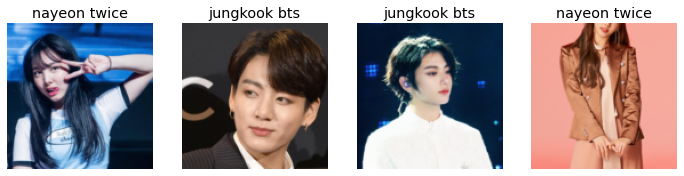

In [58]:
dls.valid.show_batch(max_n=4, nrows=1)

In [61]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.491531,0.541560,0.183908,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.475139,0.193928,0.126437,00:08
1,0.348675,0.102319,0.045977,00:08
2,0.263482,0.191297,0.045977,00:08
3,0.199018,0.205406,0.034483,00:08
4,0.161414,0.171707,0.022989,00:09
5,0.135711,0.138634,0.022989,00:07
6,0.112983,0.122420,0.022989,00:09
7,0.094961,0.116709,0.022989,00:08


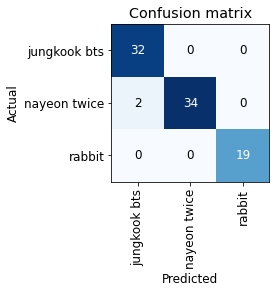

In [62]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

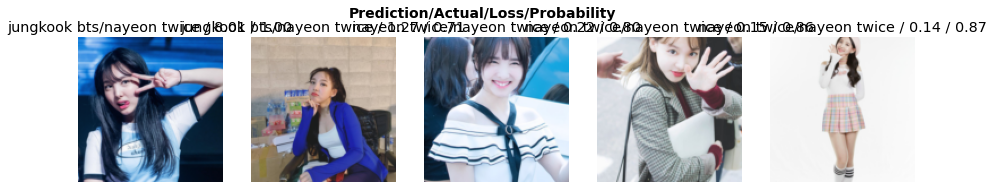

In [63]:
interp.plot_top_losses(5, nrows=1)

In [64]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [65]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [66]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.323719,0.545874,0.195402,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.422276,0.183843,0.080460,00:08
1,0.286760,0.086703,0.045977,00:08
2,0.212978,0.092250,0.045977,00:07
3,0.169050,0.137649,0.045977,00:07
4,0.134018,0.169755,0.057471,00:08
5,0.111885,0.171398,0.057471,00:10
6,0.094499,0.161396,0.057471,00:08
7,0.078836,0.171121,0.057471,00:08


# export kpop idol vs. bunny classifying model

In [67]:
learn.export()

In [68]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [69]:
learn_inf = load_learner(path/'export.pkl')

In [70]:
learn_inf.dls.vocab

['jungkook bts', 'nayeon twice', 'rabbit']

# making a notebook app for the bear classifier

In [71]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [74]:
img = PILImage.create(btn_upload.data[-1])

In [75]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [76]:
lbl_pred = widgets.Label()
lbl_pred.value = 'Please choose an image'
lbl_pred

Label(value='Please choose an image')

In [78]:
btn_run = widgets.Button(description='Kpop Idol or bunny?')
btn_run

Button(description='Kpop Idol or bunny?', style=ButtonStyle())

In [79]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [80]:
VBox([widgets.Label('Upload an image!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

# making a real app for the bear classifier

In [82]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.2.4 OK
